In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import gensim


In [2]:

# Load the dataset
df = pd.read_csv("AmazonReview/Reviews.csv")
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:

def preprocess_text(text):
    # Tokenization and lowercasing
    text = word_tokenize(str(text).lower())

    # Removing special characters and numbers
    text = [word for word in text if word.isalpha()]

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]

    return text

def process_text(text):
    # Preprocess the text
    text = preprocess_text(text)

    # Handling rare words
    word_frequencies = nltk.FreqDist(text)
    rare_words = set(word for word in word_frequencies if word_frequencies[word] < 5)
    text = [word if word not in rare_words else 'UNK' for word in text]

    # Padding sequences (assuming a maximum sequence length of 100)
    # max_seq_length = 100
    text = text[:max_seq_length] + ['PAD'] * (max_seq_length - len(text))

    return text, word_frequencies



In [4]:

max_seq_length = 100


In [5]:

# Data Preprocessing
df['Text_processed'], word_frequencies = zip(*df['Text'].map(process_text))


In [6]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate the sentiment scores for each text in the DataFrame
df['Sentiment'] = df['Text'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Map the sentiment scores to positive, negative, and neutral sentiments
df['Sentiment'] = df['Sentiment'].apply(lambda score: 1 if score > 0.2 else -1 if score < -0.2 else 0)

df.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_processed,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...",1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...",-1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...",1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...",0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"[UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, UNK, ...",1


In [7]:


# Convert the text sequences to numerical sequences
# word_index = {word: index for index, word in enumerate(word_frequencies.keys(), 1)}
word_index = {word: index+1 for index, word in enumerate(set(word for word_list in word_frequencies for word in word_list), start=1)}
word_index['UNK'] = len(word_index) + 1
word_index['PAD'] = len(word_index) + 1
numerical_sequences = df['Text_processed'].apply(lambda x: [word_index[word] for word in x])

# Pad the sequences to ensure they have the same length
padded_sequences = pad_sequences(numerical_sequences, maxlen=max_seq_length, padding='post')


In [8]:

# Split the data into training and testing sets
X = padded_sequences
y = df['Sentiment'].values
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [9]:

# Convert the labels to one-hot encoded vectors
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [10]:

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [11]:
# Train Word2Vec model
sentences = df['Text_processed'].tolist()
word2vec_model = gensim.models.Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Save the Word2Vec model
word2vec_model.save("word2vec_model.bin")

In [12]:

# Define the LSTM model with Word2Vec embedding
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:

# Set the batch size and number of epochs
batch_size = 128
epochs = 10

# Enable GPU acceleration if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


Epoch 1/10
3553/3553 [==============================] - 284s 79ms/step - loss: 0.5068 - accuracy: 0.8543 - val_loss: 0.5018 - val_accuracy: 0.8562
Epoch 2/10
3553/3553 [==============================] - 285s 80ms/step - loss: 0.5047 - accuracy: 0.8544 - val_loss: 0.5011 - val_accuracy: 0.8562
Epoch 3/10
3553/3553 [==============================] - 289s 81ms/step - loss: 0.5042 - accuracy: 0.8544 - val_loss: 0.5009 - val_accuracy: 0.8562
Epoch 4/10
3553/3553 [==============================] - 293s 82ms/step - loss: 0.5038 - accuracy: 0.8545 - val_loss: 0.5003 - val_accuracy: 0.8562
Epoch 5/10
3553/3553 [==============================] - 299s 84ms/step - loss: 0.5035 - accuracy: 0.8546 - val_loss: 0.5011 - val_accuracy: 0.8562
Epoch 6/10
3553/3553 [==============================] - 300s 84ms/step - loss: 0.5033 - accuracy: 0.8545 - val_loss: 0.5008 - val_accuracy: 0.8563


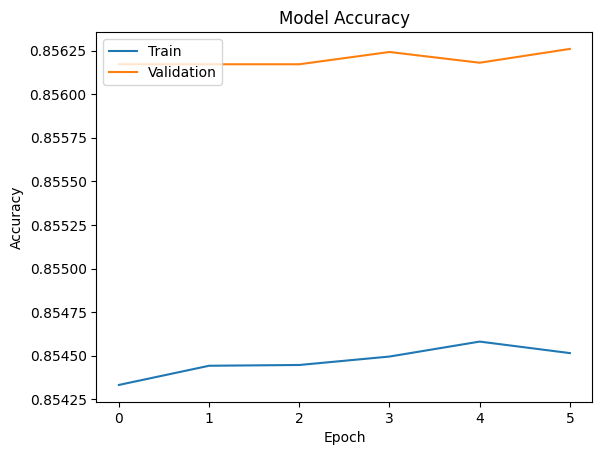

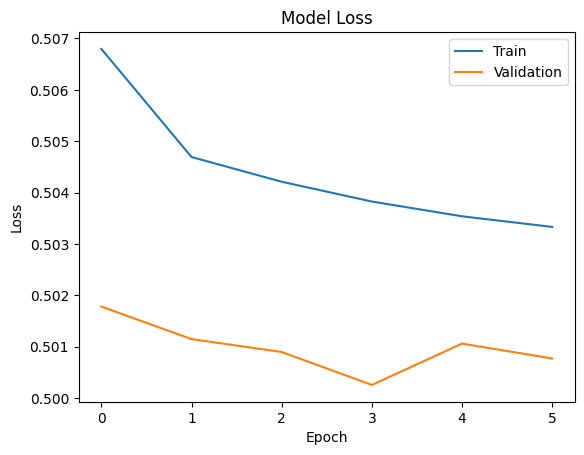

In [14]:

# Train the model and collect the training history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Save the model
model.save('sentiment_analysis_model.h5')


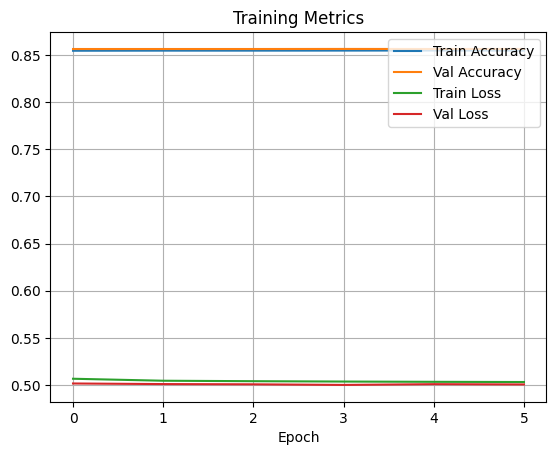

In [15]:

# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot the training and validation metrics
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'], loc='upper right')
plt.grid()
plt.show()


In [16]:

# Evaluate the loaded model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


3553/3553 [==============================] - 29s 8ms/step - loss: 0.5008 - accuracy: 0.8563
Test loss: 0.5007705092430115
Test accuracy: 0.8562595248222351


In [17]:

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels)
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

# Create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)


3553/3553 [==============================] - 27s 7ms/step


c:\Users\divya\Github\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:

# Print the evaluation metrics and confusion matrix
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Confusion Matrix:')
print(cm)


Accuracy: 0.8562595104273865
Precision: 0.7994587463654229
Recall: 0.8562595104273865
F1-score: 0.7901273549771684
Confusion Matrix:
[[    0  6296     0]
 [    0 97334     5]
 [    0 10041    15]]


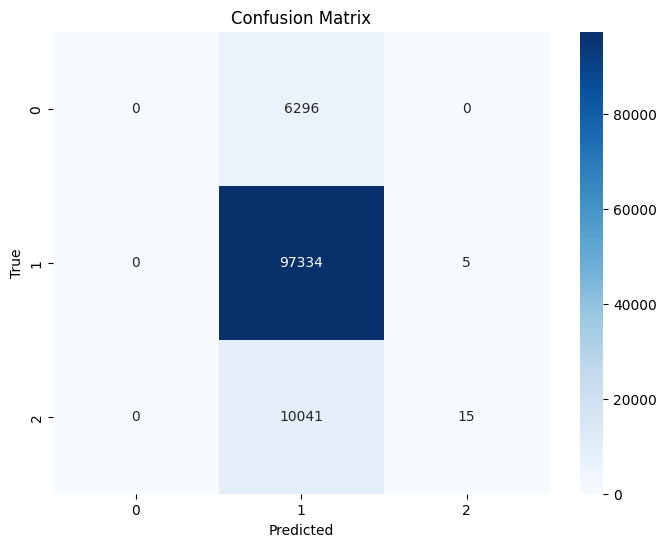

In [19]:

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
